In [8]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import scipy as sc
import sys
sys.path.append('../')
import time
import torch
import package.compute_procrustes as compute_procrustes
import package.dataset as dataset
import package.models as models
import package.training as training
from sklearn.model_selection import train_test_split

In [3]:
folder_path_X = "/network/lustre/iss02/aramis/projects/cracknetworks/X_couple/X_couple"
folder_path_Y = "/network/lustre/iss02/aramis/projects/cracknetworks/Y_folder/Y_folder"

In [4]:
X1 = np.load(folder_path_X + "/1_1000_cpl.npy")
Y1 = np.load(folder_path_Y + "/1_1000_coh.npy")

In [9]:
print(X1.shape)
print(Y1.shape)

(32000, 2, 1501)
(32000, 251)


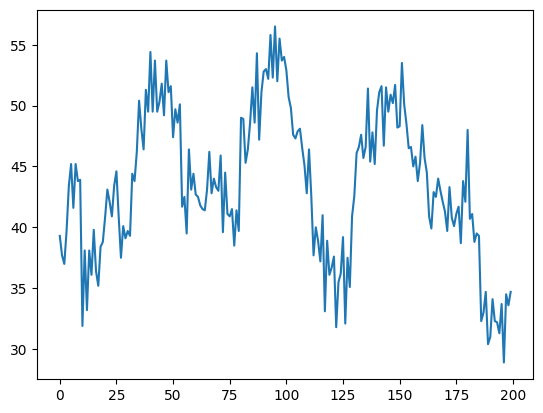

In [28]:
xa = X1[0, 0, :200]
xb = X1[0, 1, :200]
coh = Y1[0, :200]
plt.plot(xa)
plt.show()

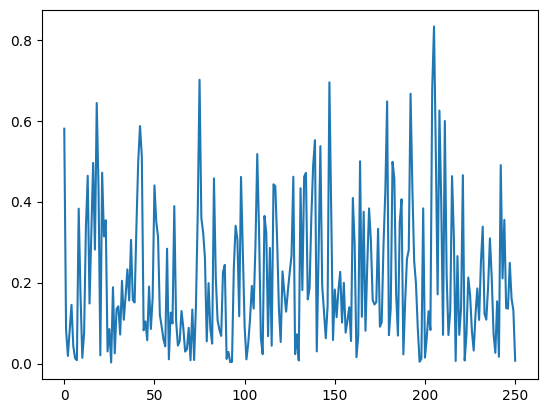

In [12]:
plt.plot(coh)

In [31]:
def compute_coherence(x, y, l):
    N = len(x)
    x = signal.detrend(x)
    y = signal.detrend(y)

    v = np.exp(- 2 * 1j * np.pi * np.arange(0, N) * l / N)
    cfx = x @ v
    cfy = y @ v
    print(cfx)
    print(cfy)
    Pxy = cfx * np.conj(cfy)
    Pxx = cfx * np.conj(cfx)
    Pyy = cfy * np.conj(cfy)
    print(np.abs(Pxy))
    print(Pxx)
    print(Pyy)
    print(np.sqrt(Pxx * Pyy))
    coh = np.abs(Pxy) / np.sqrt(Pxx * Pyy)
    return coh

In [32]:
N = len(xa)
l = 100
coh = compute_coherence(xa, xb, l)
print(coh)

(-34.053889081033454-8.687064190050534e-13j)
(-49.32488377932556+9.805668819976561e-14j)
1679.7041211560188
(1159.6673615433294+0j)
(2432.944159843974+0j)
(1679.7041211560188+0j)
(1+0j)


In [29]:
X = X1.reshape(32000,2*1501)
X = np.concatenate([X,X1[:,0,:]*X1[:,1,:]],axis=1)
X = X[:3000,:]
Y = Y1[:,0]
Y = Y[:3000]

In [30]:
#normalizer = Normalizer()
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train = torch.tensor(X_train, dtype=torch.float32)
#X_train = normalizer.fit_transform(X_train)
X_test = torch.tensor(X_test, dtype=torch.float32)
#X_test = normalizer.transform(X_test)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

trainset = dataset.Dataset(X_train, y_train)
testset = dataset.Dataset(X_test, y_test)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=True)

In [33]:
layer_sizes_list = [3*1501, 1000, 100, 1]

def f(x):
    return x

model = models.Model_MLP(layer_sizes_list, non_linearity="relu", initial_weights='xavier',type="regression")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=30, verbose=True, factor=0.5)
training.train_model(model, trainloader, testloader, device, criterion, 500, optimizer, scheduler=scheduler, type="regression")

Epoch 0
lr:  0.1
Training Loss
8767555867280.605
Test Loss
Loss: 4790871015.253333
-------------------------
Epoch 10
lr:  0.1
Training Loss
12399.653253672564
Test Loss
Loss: 7039.766749609411
-------------------------
Epoch 20
lr:  0.1
Training Loss
7071.962862435182
Test Loss
Loss: 4382.795446166992
-------------------------
Epoch 30
lr:  0.1
Training Loss
1243141.5882494673
Test Loss
Loss: 49018.7931591855
-------------------------
Epoch 40
lr:  0.1
Training Loss
20523.050713545566
Test Loss
Loss: 45639.54035320609
-------------------------
Epoch 50
lr:  0.1
Training Loss
16909.53715603618
Test Loss
Loss: 42439.18599565542
-------------------------
Epoch 60
lr:  0.05
Training Loss
13721.846349442167
Test Loss
Loss: 38145.55447065879
-------------------------
Epoch 70
lr:  0.05
Training Loss
11789.951430294974
Test Loss
Loss: 35691.64956047433
-------------------------
Epoch 80
lr:  0.05
Training Loss
9805.925272058224
Test Loss
Loss: 33733.32387664375
-------------------------
Epoc

KeyboardInterrupt: 

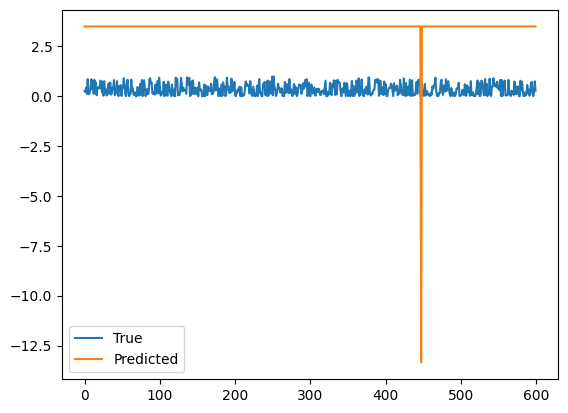

10.318138020833333


In [34]:
#display results
model.eval()
y_pred = model(X_test.to(device)).detach().cpu().numpy()
plt.plot(y_test.flatten(), label="True")
plt.plot(y_pred.flatten(), label="Predicted")
plt.legend()
plt.show()
print(np.sum((y_test.numpy() - y_pred)**2)/len(y_test))